<a href="https://colab.research.google.com/github/Jaew00/ElasticSearch/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Nickel_Final_DB1.csv')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['NetWeight'] = pd.to_numeric(df['NetWeight']).astype(float)

df.set_index('Date', inplace = True)

In [6]:
df

,Price,Y2_Price,Y10_Price,UC_Price,EU_Price,GB_Price,JP_Price,NetWeight,TradeValue,WTI_Price,B_Price,Gas_Price,heating_Price,NAV,Dollor_Price,Stock,STS_price,Current_Price,CRB_Price
Date,,,,,,,,,,,,,,,,,,,
2011-01-04,25120.0,0.6210,3.338,6.6070,0.7514,0.6415,82.06,779926682.0,155396452.0,89.38,93.53,4.669,2.5065,31.64,79.440,136890.0,100.700,25175.0,327.76
2011-01-05,24720.0,0.7080,3.463,6.6193,0.7603,0.6448,83.19,779926682.0,155396452.0,90.30,95.50,4.473,2.5422,31.91,80.260,136860.0,100.700,24650.0,329.23
2011-01-06,24534.0,0.6770,3.399,6.6263,0.7686,0.6464,83.31,779926682.0,155396452.0,88.38,94.52,4.434,2.5112,31.57,80.790,137040.0,100.700,24875.0,325.10
2011-01-07,24180.0,0.5970,3.328,6.6282,0.7746,0.6428,83.14,779926682.0,155396452.0,88.03,93.33,4.422,2.4863,31.65,81.010,136896.0,100.700,24345.0,323.98
2011-01-10,23847.0,0.5730,3.287,6.6369,0.7723,0.6421,82.72,779926682.0,155396452.0,89.25,95.70,4.399,2.5561,31.88,80.880,136806.0,100.700,24050.0,326.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,27732.0,2.6287,2.861,6.6490,0.9352,1.2588,127.87,49104116.0,16801717.0,109.77,110.78,8.796,3.7818,22.44,102.097,71922.0,177.145,26800.0,335.74
2022-05-24,26550.0,2.4807,2.754,6.6530,0.9314,1.2529,126.80,49104116.0,16801717.0,110.33,110.69,8.971,3.8664,22.17,101.870,72120.0,177.145,26280.0,334.21
2022-05-25,26788.0,2.5020,2.751,6.6916,0.9360,1.2564,127.31,49104116.0,16801717.0,114.09,111.12,8.908,3.9680,22.06,102.077,72600.0,177.145,26725.0,335.09


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2783 entries, 2011-01-04 to 2022-05-27
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          2783 non-null   float64
 1   Y2_Price       2783 non-null   float64
 2   Y10_Price      2783 non-null   float64
 3   UC_Price       2783 non-null   float64
 4   EU_Price       2783 non-null   float64
 5   GB_Price       2783 non-null   float64
 6   JP_Price       2783 non-null   float64
 7   NetWeight      2783 non-null   float64
 8   TradeValue     2783 non-null   float64
 9   WTI_Price      2783 non-null   float64
 10  B_Price        2783 non-null   float64
 11  Gas_Price      2783 non-null   float64
 12  heating_Price  2783 non-null   float64
 13  NAV            2783 non-null   float64
 14  Dollor_Price   2783 non-null   float64
 15  Stock          2783 non-null   float64
 16  STS_price      2783 non-null   float64
 17  Current_Price  2783 non-null   flo

In [8]:
lag_col = list(df.columns)

In [9]:
lag_amount = 3

for col in lag_col :
  for i in range(lag_amount) :
    df['{0}_lag{1}'.format(col, i+1)] = df['{}'.format(col)].shift(i+1)

print(df.shape)
df.dropna(inplace=True)

(2783, 76)


In [10]:
df.isnull().sum().sum()

0

In [11]:
print(df.shape)
print(df['Price'].shape)

(2780, 76)
(2780,)


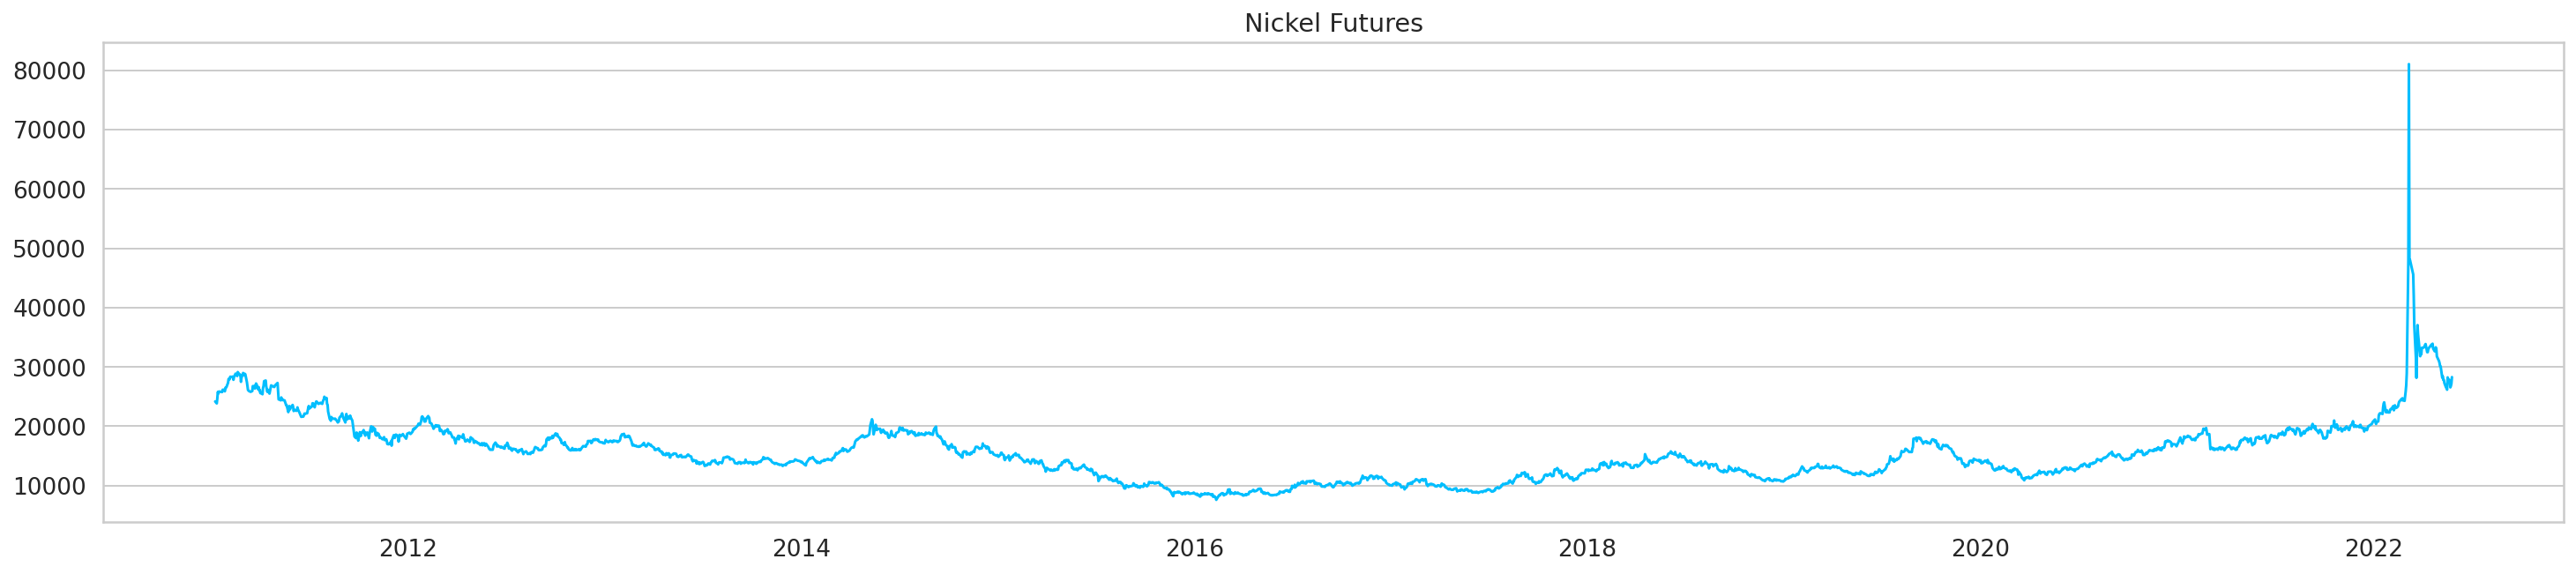

In [12]:
plt.figure(figsize=(25,5))
plt.plot(df['Price'])
plt.title("Nickel Futures")
plt.grid(axis='x')

In [13]:
x_cols = list(df.columns)
x_cols.remove("Price")

In [14]:
test_data_size = 90

X = df[x_cols]
Y = df['Price']

In [15]:
X.columns

Index(['Y2_Price', 'Y10_Price', 'UC_Price', 'EU_Price', 'GB_Price', 'JP_Price',
       'NetWeight', 'TradeValue', 'WTI_Price', 'B_Price', 'Gas_Price',
       'heating_Price', 'NAV', 'Dollor_Price', 'Stock', 'STS_price',
       'Current_Price', 'CRB_Price', 'Price_lag1', 'Price_lag2', 'Price_lag3',
       'Y2_Price_lag1', 'Y2_Price_lag2', 'Y2_Price_lag3', 'Y10_Price_lag1',
       'Y10_Price_lag2', 'Y10_Price_lag3', 'UC_Price_lag1', 'UC_Price_lag2',
       'UC_Price_lag3', 'EU_Price_lag1', 'EU_Price_lag2', 'EU_Price_lag3',
       'GB_Price_lag1', 'GB_Price_lag2', 'GB_Price_lag3', 'JP_Price_lag1',
       'JP_Price_lag2', 'JP_Price_lag3', 'NetWeight_lag1', 'NetWeight_lag2',
       'NetWeight_lag3', 'TradeValue_lag1', 'TradeValue_lag2',
       'TradeValue_lag3', 'WTI_Price_lag1', 'WTI_Price_lag2', 'WTI_Price_lag3',
       'B_Price_lag1', 'B_Price_lag2', 'B_Price_lag3', 'Gas_Price_lag1',
       'Gas_Price_lag2', 'Gas_Price_lag3', 'heating_Price_lag1',
       'heating_Price_lag2', 'heating_Pr

In [16]:
scaler = MinMaxScaler()

Xscaler = scaler.fit(X)
Yscaler = scaler.fit(Y.values.reshape(-1,1))

Y = Y.values.reshape(-1, 1)

x_train = scaler.fit_transform(X[:-test_data_size])
x_test = scaler.transform(X[-test_data_size:])
y_train = scaler.fit_transform(Y[:-test_data_size]).flatten()
y_test = scaler.transform(Y[-test_data_size:]).flatten()


'''xscaler = scaler.fit(X)
yscaler = scaler.fit(Y.values.reshape(-1, 1))

x = xscaler.transform(X)
y = yscaler.transform(Y.values.reshape(-1, 1))

x_train, x_test = x[:-test_data_size], x[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()'''

'xscaler = scaler.fit(X)\nyscaler = scaler.fit(Y.values.reshape(-1, 1))\n\nx = xscaler.transform(X)\ny = yscaler.transform(Y.values.reshape(-1, 1))\n\nx_train, x_test = x[:-test_data_size], x[-test_data_size:]\ny_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()'

In [17]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2690, 75)
(90, 75)
(2690,)
(90,)


In [18]:
def create_sequences(array, seq_length) :
  res = []
  if seq_length == 1:
    for i in range(len(array)) :
      tmp = array[i:(i+seq_length)]
      res.append(tmp)

  else :
    for i in range(len(array) - seq_length-1) :
      tmp = array[i:(i+seq_length)]
      res.append(tmp)

  return res

In [19]:
seq_length = 1

x_train = create_sequences(x_train, seq_length)
x_test = create_sequences(x_test, seq_length)
y_train = create_sequences(y_train, seq_length)
y_test = create_sequences(y_test, seq_length)

In [20]:
x_train = torch.tensor(x_train, device=device).float()
x_test = torch.tensor(x_test, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()

In [21]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([2690, 1, 75])
torch.Size([90, 1, 75])
torch.Size([2690, 1])
torch.Size([90, 1])


# Building a Model

In [22]:
class LSTM(nn.Module) :
  def __init__(self, n_features, n_hidden, seq_len, n_layers = 2) :
    super(LSTM, self).__init__() 

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(input_size = n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        )
    
    self.linear = nn.Linear(in_features = n_hidden, out_features = 1)


  def reset_hidden_state(self) :
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=device),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=device)
    )

  def forward(self, sequences) :
    lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)

    return y_pred

# Training

In [23]:
def train_model(model, train_data, train_labels, test_data = None, test_labels=None, num_epochs = 250, lr = 1e-3) :
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for i in range(num_epochs) :
    model.reset_hidden_state()
    y_pred = model(x_train)
    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None :
      with torch.no_grad() :
        y_test_pred = model(x_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[i] = test_loss.item()

      if i % 10 == 0:
        print(f'Epoch {i} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
    elif i % 10 == 0 :
      print(f'Epoch {i} train loss: {round(loss.item(),4)}')

    train_hist[i] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return model.eval(), train_hist, test_hist


In [24]:
n_features = x_train.shape[-1]
n_hidden = 64
n_layers = 4
lr = 1e-4
num_epochs = 1000

In [25]:
model = LSTM(n_features=n_features, n_hidden=n_hidden, seq_len = seq_length, n_layers=n_layers).to(device)
model, train_hist, test_hist = train_model(model, x_train, y_train, x_test, y_test, num_epochs=num_epochs, lr=1e-4)

Epoch 0 train loss: 0.2118 test loss: 1.3681
Epoch 10 train loss: 0.1916 test loss: 1.3118
Epoch 20 train loss: 0.1724 test loss: 1.2563
Epoch 30 train loss: 0.1519 test loss: 1.1933
Epoch 40 train loss: 0.127 test loss: 1.1074
Epoch 50 train loss: 0.0925 test loss: 0.9696
Epoch 60 train loss: 0.0477 test loss: 0.736
Epoch 70 train loss: 0.0337 test loss: 0.4666
Epoch 80 train loss: 0.0273 test loss: 0.5058
Epoch 90 train loss: 0.0241 test loss: 0.5475
Epoch 100 train loss: 0.0187 test loss: 0.4732
Epoch 110 train loss: 0.0146 test loss: 0.4237
Epoch 120 train loss: 0.0125 test loss: 0.4009
Epoch 130 train loss: 0.0111 test loss: 0.3485
Epoch 140 train loss: 0.0094 test loss: 0.3183
Epoch 150 train loss: 0.008 test loss: 0.2801
Epoch 160 train loss: 0.0068 test loss: 0.2457
Epoch 170 train loss: 0.0061 test loss: 0.2154
Epoch 180 train loss: 0.0055 test loss: 0.1992
Epoch 190 train loss: 0.005 test loss: 0.193
Epoch 200 train loss: 0.0045 test loss: 0.1888
Epoch 210 train loss: 0.0042 

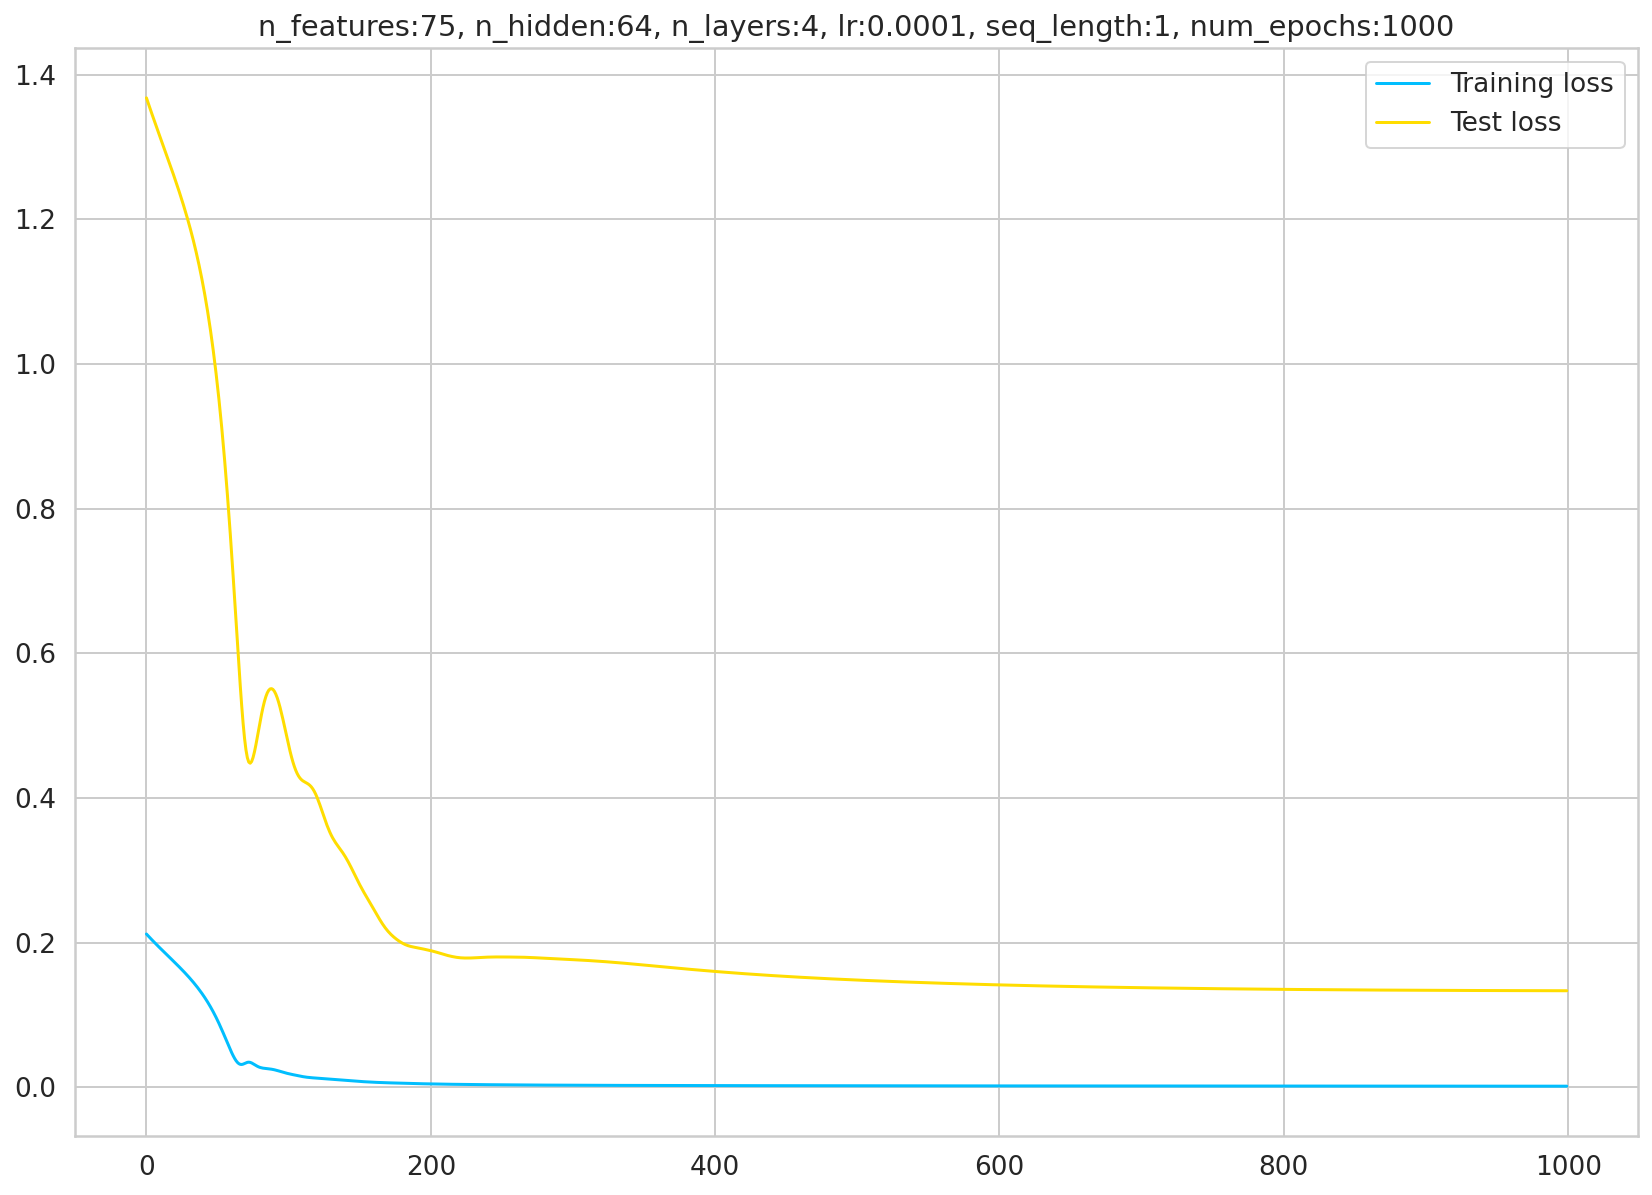

In [26]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

In [27]:
with torch.no_grad():
  preds = []
  for i in range(len(x_test)):
    test_seq = x_test[i:i+1]
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [28]:
preds

[0.9694382548332214,
 0.9570336937904358,
 0.9406843781471252,
 0.9209170341491699,
 0.8984613418579102,
 0.8742950558662415,
 0.849486231803894,
 0.8250208497047424,
 0.801594078540802,
 0.7797186374664307,
 0.7596936821937561,
 0.741698682308197,
 0.7258611917495728,
 0.7123240828514099,
 0.7013960480690002,
 0.6931319236755371,
 0.6876381039619446,
 0.6848628520965576,
 0.6846001148223877,
 0.6863976120948792,
 0.6898753643035889,
 0.6945659518241882,
 0.700142502784729,
 0.7061799764633179,
 0.712316632270813,
 0.7182151675224304,
 0.7237107753753662,
 0.7289689779281616,
 0.7342507243156433,
 0.7398945689201355,
 0.7459464073181152,
 0.7521215081214905,
 0.7583417892456055,
 0.7648692727088928,
 0.7722699046134949,
 0.7813554406166077,
 0.793908417224884,
 0.8122223615646362,
 0.8383432626724243,
 0.8714084625244141,
 0.9075263142585754,
 0.942467987537384,
 0.973820149898529,
 1.0002564191818237,
 1.0213061571121216,
 1.0371826887130737,
 1.0485042333602905,
 1.0562005043029785,


In [29]:
pred_values = Yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [30]:
pred_values

array([[28469.7611326 ],
       [28202.59169686],
       [27850.46013653],
       [27424.7110815 ],
       [26941.06038094],
       [26420.56691325],
       [25886.23446059],
       [25359.29906094],
       [24854.73326361],
       [24383.58001375],
       [23952.28252709],
       [23564.70621955],
       [23223.5983479 ],
       [22932.03609645],
       [22696.66808331],
       [22518.67537212],
       [22400.34948313],
       [22340.57610846],
       [22334.91727304],
       [22373.6317693 ],
       [22448.53559637],
       [22549.56147039],
       [22669.66922498],
       [22799.70433307],
       [22931.87562585],
       [23058.9182781 ],
       [23177.28268003],
       [23290.53384662],
       [23404.29210031],
       [23525.8492254 ],
       [23656.19372082],
       [23789.19304192],
       [23923.16545677],
       [24063.7543956 ],
       [24223.14920557],
       [24418.83348   ],
       [24689.19949019],
       [25083.64522338],
       [25646.23719144],
       [26358.39546585],


In [31]:
pred_values_ceiled  = list(pred_values.flatten())

In [32]:
# True value 스케일링 역변환
true_values = Yscaler.inverse_transform(np.array(y_test.cpu()).reshape(-1,1))

In [33]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [34]:
score_table

,True,Pred
0,22064.000000,28469.761133
1,22176.000000,28202.591697
2,22193.998047,27850.460137
3,22072.998047,27424.711082
4,23154.000000,26941.060381
...,...,...
85,27731.998047,29094.967447
86,26550.000000,28971.741428
87,26788.000000,28855.190985
88,27197.998047,28746.058136


In [35]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [36]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 64792072.17377198, RMSE : 8049.352282871708, SCORE : 93.08415976210196


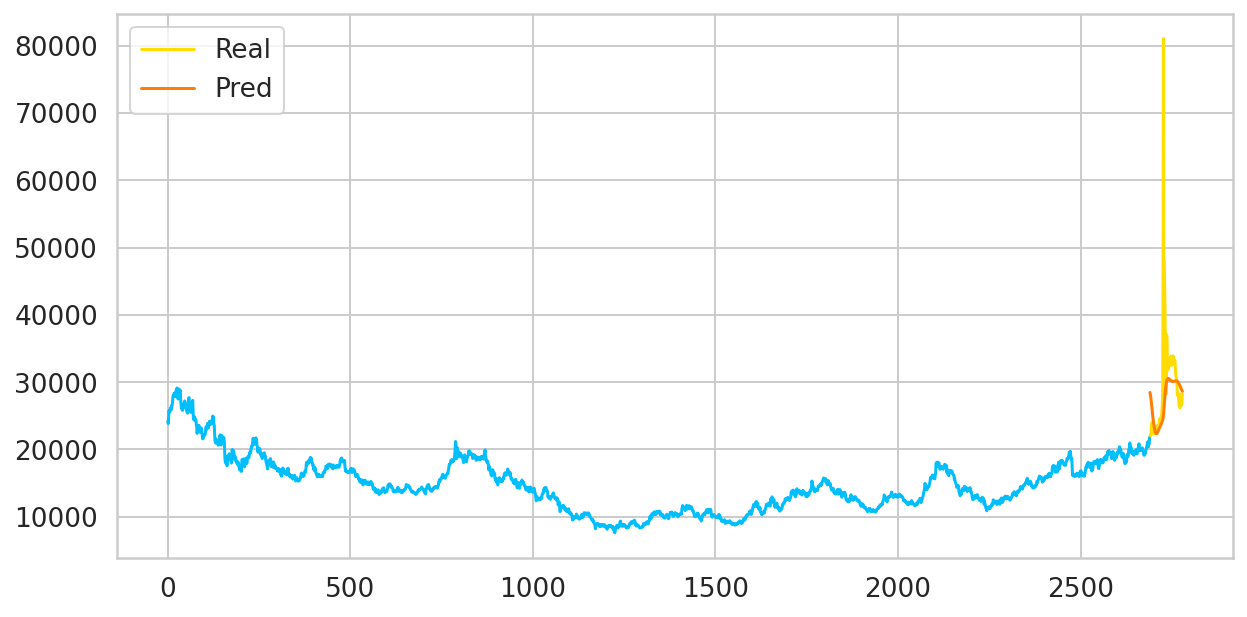

In [37]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),Yscaler.inverse_transform(np.array(y_train.cpu()).reshape(-1,1)))
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [38]:
# 모델 저장
PATH = '/content/gdrive/MyDrive/Colab Notebooks/Elastic/weights/{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))

torch.save(model, PATH)

In [39]:
# 모델 불러오기
model = torch.load(PATH)

# Use all data for Training

In [40]:
# X변수들과 y변수 구분
X_all = df[x_cols]
y_all = df['Price']

In [41]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = scaler.fit_transform(X_all)
y_all = scaler.fit_transform(y_all.values.reshape(-1,1)).flatten()


In [42]:
y_all

array([0.22583104, 0.22129809, 0.23252838, ..., 0.26133239, 0.26691351,
       0.28169666])

In [43]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (2780, 75)
y_all :  (2780,)


In [44]:
X_all = create_sequences(X_all, seq_length)
y_all = create_sequences(y_all, seq_length)

In [45]:
X_all = torch.tensor(X_all, device=device).float()
y_all = torch.tensor(y_all, device=device).float()
#X_all = torch.from_numpy(np.array(X_all)).float()
#y_all = torch.from_numpy(np.array(y_all)).float()

In [46]:
DAYS_TO_PREDICT = 100
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.cpu().numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [47]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [48]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[78764.87281239033,
 77723.83373749256,
 76236.31416463852,
 74286.01666021347,
 71892.79852175713,
 69112.21201694012,
 66031.06002700329,
 62759.32176744938,
 59419.32432126999,
 56133.285304546356,
 53011.12700998783,
 50140.71633720398,
 47582.25570821762,
 45367.21029174328,
 43501.20230829716,
 41969.405559539795,
 40742.80693554878,
 39784.21833753586,
 39053.231150209904,
 38509.90527665615,
 38117.17741036415,
 37842.25564366579,
 37657.19088500738,
 37538.889994978905,
 37468.83555102348,
 37432.534134209156,
 37418.947101294994,
 37419.87975937128,
 37429.420895278454,
 37443.44360649586,
 37459.178380191326,
 37474.87155646086,
 37489.4810103178,
 37502.48130059242,
 37513.66444015503,
 37523.052322387695,
 37530.77849692106,
 37537.046572208405,
 37542.092996776104,
 37546.11918973923,
 37549.33313822746,
 37551.899042606354,
 37553.97891390324,
 37555.664704322815,
 37557.07463812828,
 37558.26563811302,
 37559.29462707043,
 37560.19882375002,
 37561.013257563114,
 37561.

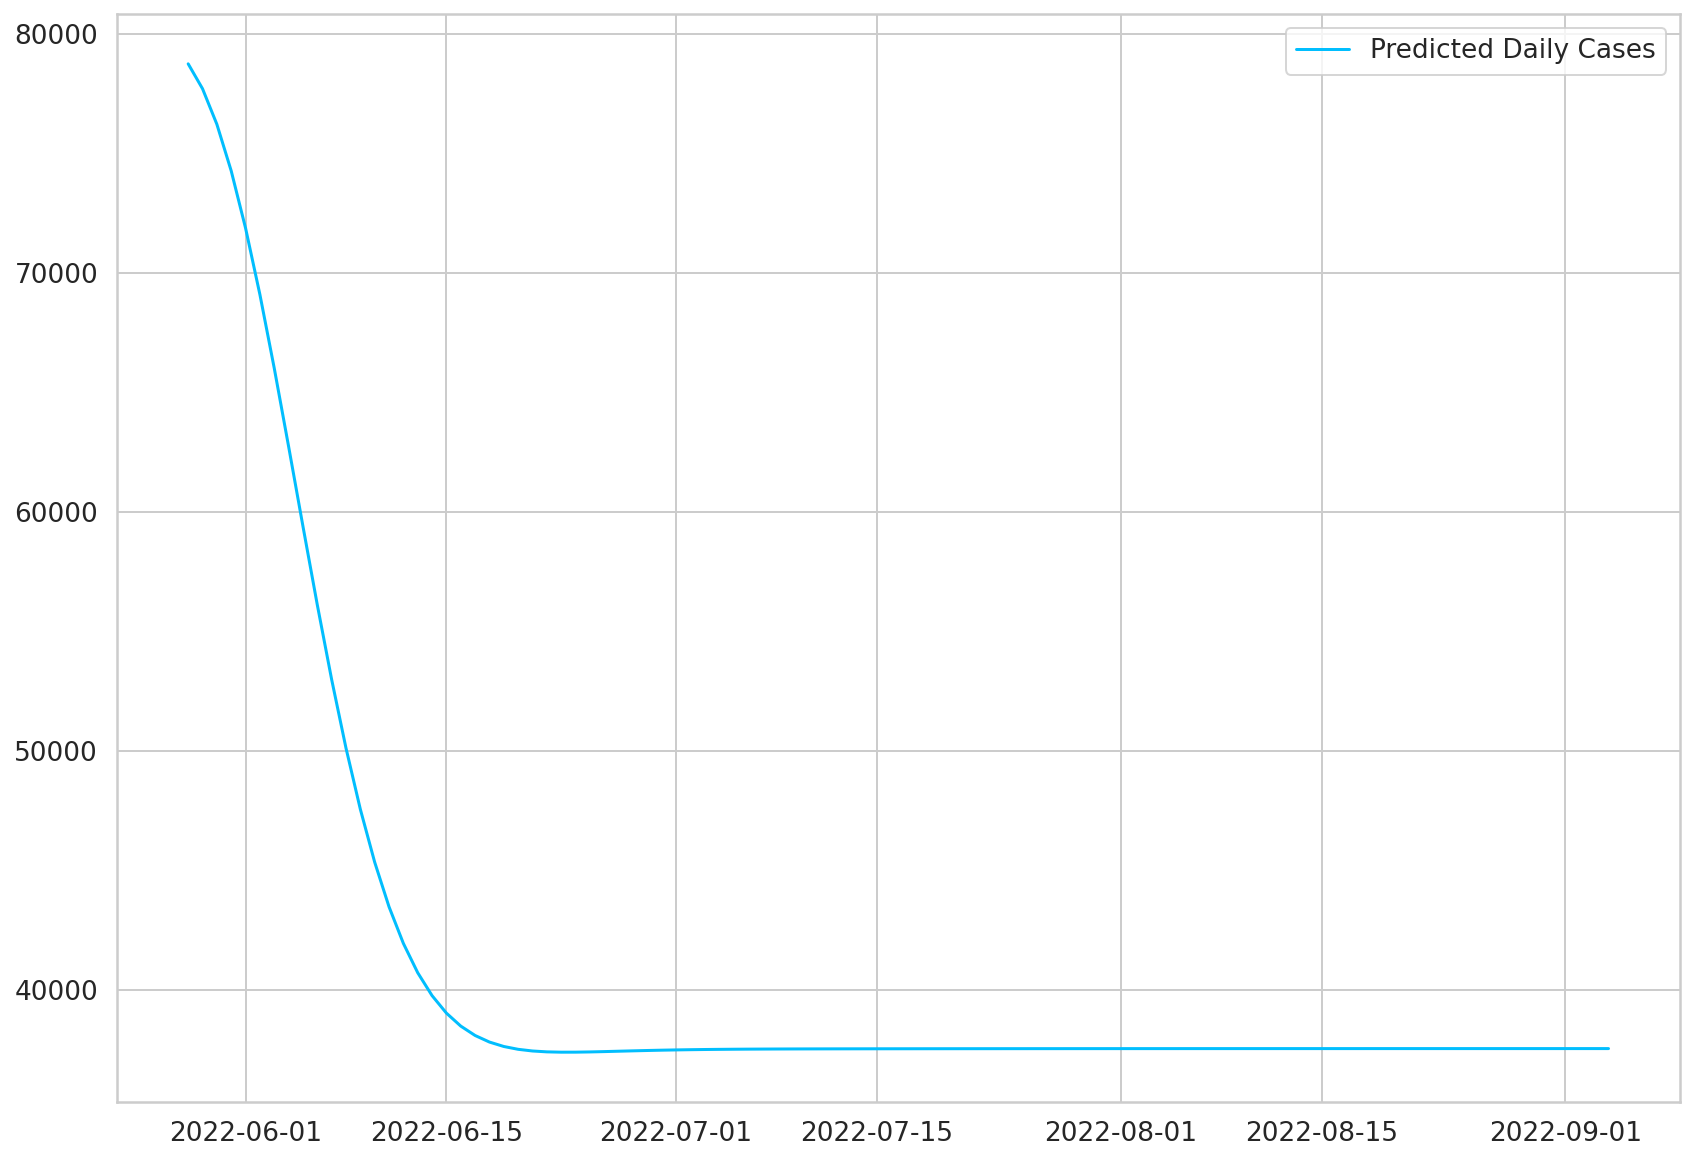

In [49]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [50]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [51]:
preds_

,0
2022-05-28,78764.872812
2022-05-29,77723.833737
2022-05-30,76236.314165
2022-05-31,74286.016660
2022-06-01,71892.798522
...,...
2022-08-31,37569.275820
2022-09-01,37569.280199
2022-09-02,37569.288956
2022-09-03,37569.291145


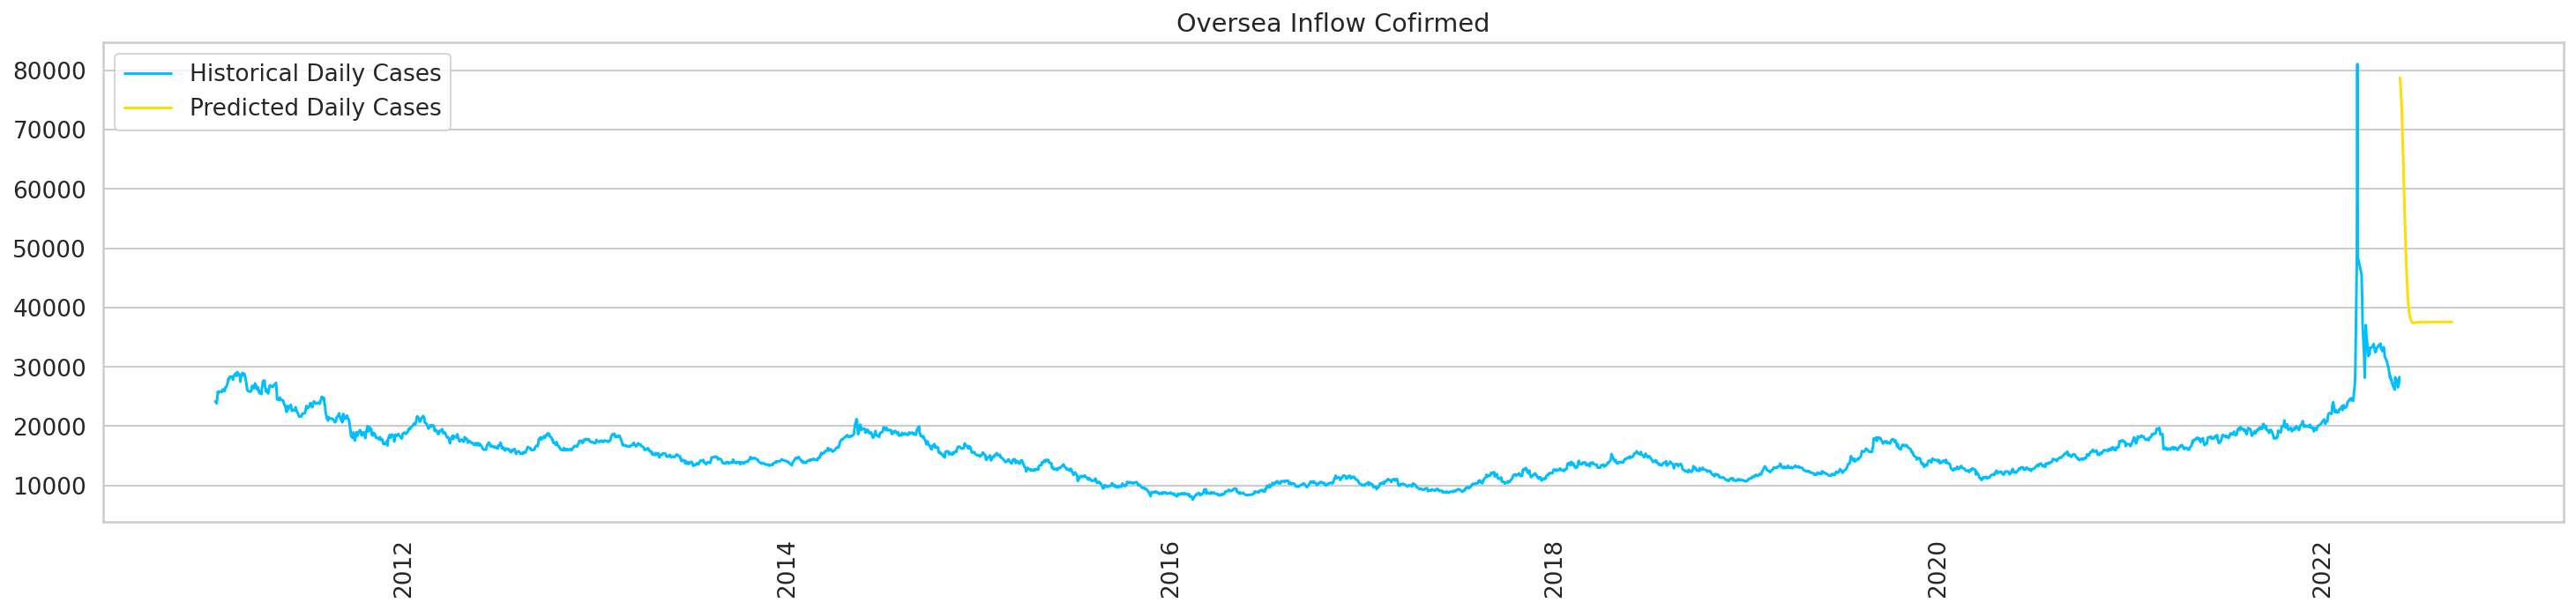

In [52]:
plt.figure(figsize=(25,5))
plt.plot(df['Price'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();